
# 🌾 Kaggle Paddy Explore Dataset 

Take a look at the metadata and data

## 1) Setup

In [17]:

# If needed:
# !pip install -q timm pandas

import os, random
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import timm
from torchvision import transforms

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

DATA_DIR = Path("./data/") 
TRAIN_CSV = DATA_DIR / 'train.csv'
TRAIN_IMG_ROOT = DATA_DIR   / 'train_images'
assert TRAIN_CSV.exists(), f"Missing {TRAIN_CSV}"
assert TRAIN_IMG_ROOT.exists(), f"Missing {TRAIN_IMG_ROOT} (folder of label subdirs)"



Device: cuda


## There is a lot of meta data.  Is there a correlation between it and the target (label)?

In [19]:
import pandas as pd
csv_path = DATA_DIR / "train.csv"

df = pd.read_csv(csv_path)
print(f"Loaded CSV: {csv_path} (rows={len(df)}, cols={len(df.columns)})")

n_varieties = df['variety'].unique()
# print(f"Number of unique varieties: {n_varieties}")

df.head()

Loaded CSV: data/train.csv (rows=10407, cols=4)


,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [20]:
print(f'Number unique labels: {len(df.label.unique())}')
print(f'Number unique ages: {len(df.age.unique())}')
print(f'Number unique varieties: {len(df.variety.unique())}')

Number unique labels: 10
Number unique ages: 18
Number unique varieties: 10


Categorical vs Categorical: variety vs label
Contingency table shape: (10, 10)


label,bacterial_leaf_blight,bacterial_leaf_streak,bacterial_panicle_blight,blast,brown_spot,dead_heart,downy_mildew,hispa,normal,tungro
variety,,,,,,,,,,
ADT45,406,107,260,793,835,979,331,833,1457,991
AndraPonni,0,0,14,112,0,70,0,181,0,0
AtchayaPonni,0,0,0,27,0,0,55,340,0,39
IR20,10,0,0,22,0,82,0,0,0,0
KarnatakaPonni,10,35,0,533,110,113,121,66,0,0


Chi2=7077.03, p-value=0.000e+00, dof=81, n=10407
Cramér's V = 0.2749  (0=no association, 1=perfect association)


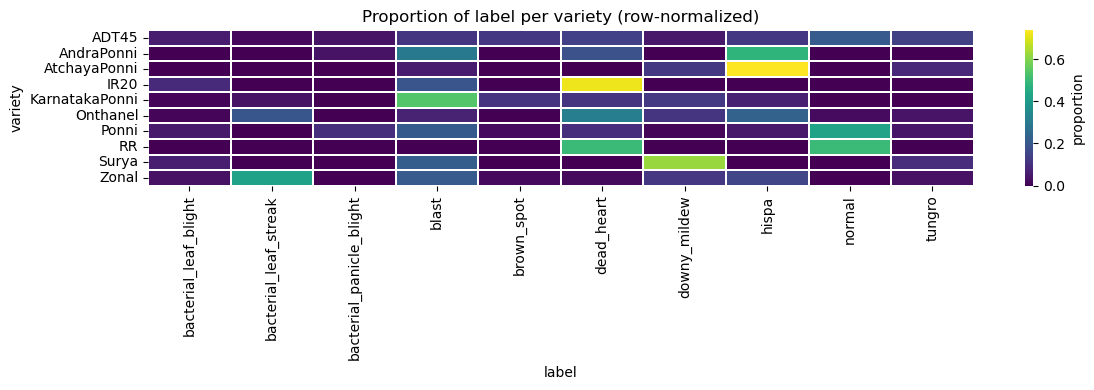

Categorical (by) vs Numeric: label -> age


,count,mean
label,,
normal,1764,62.056689
blast,1738,63.801496
hispa,1594,62.098494
dead_heart,1442,69.999307
tungro,1088,63.272059
brown_spot,965,64.981347
downy_mildew,620,60.319355
bacterial_leaf_blight,479,60.810021
bacterial_leaf_streak,380,62.986842


One-way ANOVA: F=157.729, p=5.926e-281
Kruskal-Wallis: H=1431.293, p=1.338e-302


/tmp/ipykernel_2457428/1521085751.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col_a, y=col_b, data=df, order=summary.index, palette="Set3")


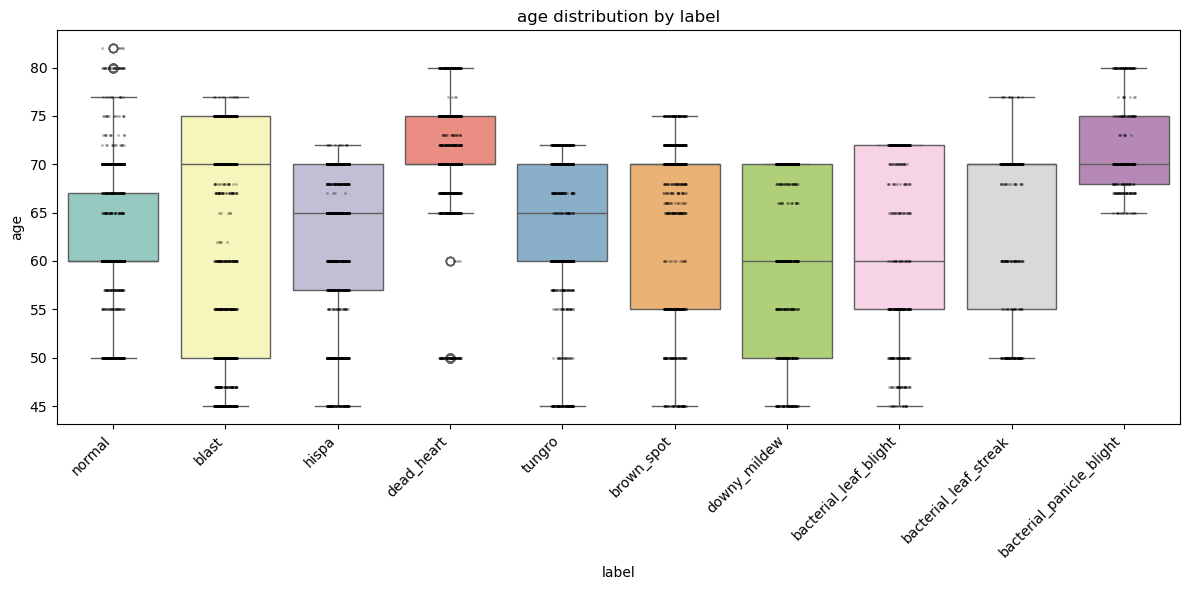

Contingency table shape: (10, 10)


label,bacterial_leaf_blight,bacterial_leaf_streak,bacterial_panicle_blight,blast,brown_spot,dead_heart,downy_mildew,hispa,normal,tungro
variety,,,,,,,,,,
ADT45,406,107,260,793,835,979,331,833,1457,991
AndraPonni,0,0,14,112,0,70,0,181,0,0
AtchayaPonni,0,0,0,27,0,0,55,340,0,39
IR20,10,0,0,22,0,82,0,0,0,0
KarnatakaPonni,10,35,0,533,110,113,121,66,0,0


Chi2=7077.03, p-value=0.000e+00, dof=81, n=10407
Cramér's V = 0.2749  (0=no association, 1=perfect association)

Top varieties by dominance of a single label:


,dominant_label,dominant_prop
variety,,
AtchayaPonni,hispa,0.737527
IR20,dead_heart,0.719298
Surya,downy_mildew,0.625000
KarnatakaPonni,blast,0.539474
RR,dead_heart,0.500000
AndraPonni,hispa,0.480106
Ponni,normal,0.427702
Zonal,bacterial_leaf_streak,0.423559
Onthanel,dead_heart,0.313390


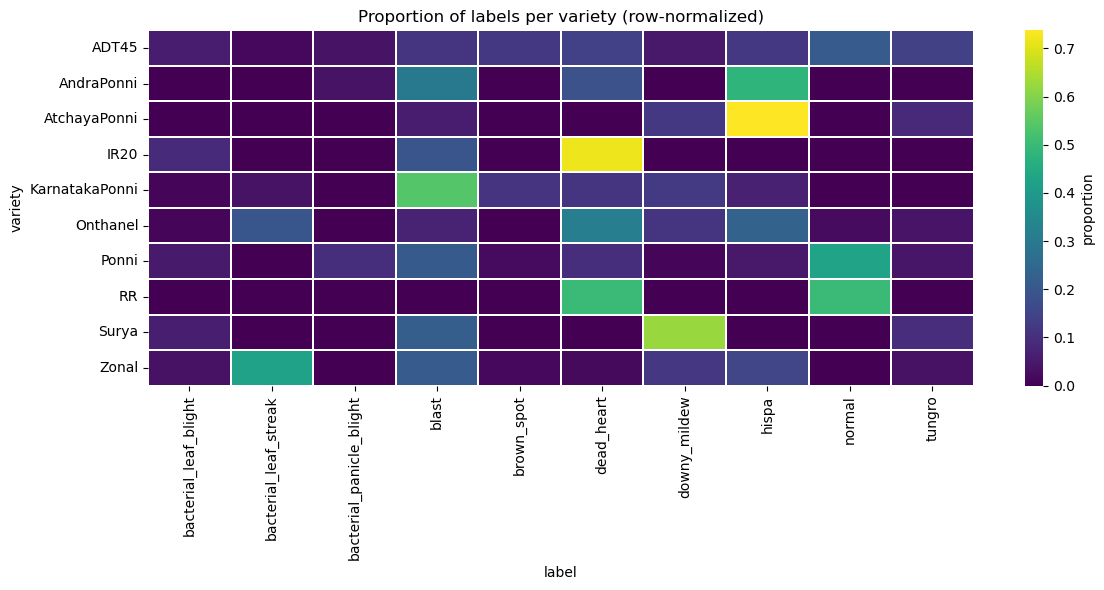

In [13]:
import seaborn as sns
from scipy.stats import chi2_contingency
from math import sqrt
from scipy.stats import f_oneway, kruskal
import matplotlib.pyplot as plt

def investigate_relation(df, col_a, col_b):
    """
    Quick investigation for:
     - categorical vs categorical: chi2 + Cramér's V + heatmap of proportions
     - categorical (col_a) vs numeric (col_b): group stats + ANOVA/Kruskal + boxplot
    """

    # detect numeric vs categorical
    is_b_numeric = pd.api.types.is_numeric_dtype(df[col_b])
    is_a_numeric = pd.api.types.is_numeric_dtype(df[col_a])

    if not is_b_numeric and not is_a_numeric:
        # categorical vs categorical
        print(f"Categorical vs Categorical: {col_a} vs {col_b}")
        cont = pd.crosstab(df[col_a], df[col_b])
        print("Contingency table shape:", cont.shape)
        display(cont.head())

        chi2, p, dof, expected = chi2_contingency(cont.values)
        n = cont.values.sum()
        min_dim = min(cont.shape)
        cramers_v = sqrt(chi2 / (n * (min_dim - 1))) if min_dim > 1 else 0.0
        print(f"Chi2={chi2:.2f}, p-value={p:.3e}, dof={dof}, n={n}")
        print(f"Cramér's V = {cramers_v:.4f}  (0=no association, 1=perfect association)")

        prop_by_a = cont.div(cont.sum(axis=1), axis=0)
        plt.figure(figsize=(12, max(4, prop_by_a.shape[0]*0.25)))
        sns.heatmap(prop_by_a, cmap="viridis", cbar_kws={'label': 'proportion'}, linewidths=0.2)
        plt.title(f"Proportion of {col_b} per {col_a} (row-normalized)")
        plt.xlabel(col_b)
        plt.ylabel(col_a)
        plt.tight_layout()
        plt.show()
        return cont

    # treat case: col_a categorical, col_b numeric (common: label vs age)
    if not is_a_numeric and is_b_numeric:
        print(f"Categorical (by) vs Numeric: {col_a} -> {col_b}")
        groups = df.groupby(col_a)[col_b].apply(lambda s: s.dropna().values)
        counts = groups.map(len).sort_values(ascending=False)
        means = df.groupby(col_a)[col_b].mean().sort_values(ascending=False)
        summary = pd.DataFrame({'count': counts, 'mean': means}).fillna(0).sort_values('count', ascending=False)
        display(summary.head(20))

        # ANOVA (requires >=2 groups with >0 samples)
        valid_groups = [g for g in groups if len(g) > 0]
        if len(valid_groups) >= 2:
            try:
                f_stat, p_val = f_oneway(*valid_groups)
                print(f"One-way ANOVA: F={f_stat:.3f}, p={p_val:.3e}")
            except Exception as e:
                print("ANOVA failed:", e)
            try:
                kw_stat, kw_p = kruskal(*valid_groups)
                print(f"Kruskal-Wallis: H={kw_stat:.3f}, p={kw_p:.3e}")
            except Exception as e:
                print("Kruskal-Wallis failed:", e)
        else:
            print("Not enough groups for ANOVA/Kruskal.")

        # boxplot + swarm
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=col_a, y=col_b, data=df, order=summary.index, palette="Set3")
        sns.stripplot(x=col_a, y=col_b, data=df, order=summary.index, color='k', size=2, alpha=0.3)
        plt.xticks(rotation=45, ha='right')
        plt.title(f"{col_b} distribution by {col_a}")
        plt.tight_layout()
        plt.show()
        return

    # fallback: numeric vs categorical (swap)
    if is_a_numeric and not is_b_numeric:
        # reuse previous logic by swapping
        investigate_relation(df, col_b, col_a)
        return

    # both numeric or other unknown combination
    print(f"Unhandled combination: {col_a} (numeric={is_a_numeric}), {col_b} (numeric={is_b_numeric})")
    print("Showing simple correlation if both numeric:")
    if is_a_numeric and is_b_numeric:
        corr = df[[col_a, col_b]].corr().iloc[0,1]
        print(f"Pearson correlation: {corr:.4f}")
        sns.scatterplot(x=col_a, y=col_b, data=df, alpha=0.5)
        plt.tight_layout()
        plt.show()


# Run investigations requested
ct=investigate_relation(df, 'variety', 'label')   # categorical vs categorical
investigate_relation(df, 'label', 'age')       # label (categorical) vs age (numeric)
cont = pd.crosstab(df['variety'], df['label'])
print("Contingency table shape:", cont.shape)
display(cont.head())

# Chi-squared test + Cramér's V (effect size for nominal association)
chi2, p, dof, expected = chi2_contingency(cont.values)
n = cont.values.sum()
min_dim = min(cont.shape)
cramers_v = sqrt(chi2 / (n * (min_dim - 1))) if min_dim > 1 else 0.0

print(f"Chi2={chi2:.2f}, p-value={p:.3e}, dof={dof}, n={n}")
print(f"Cramér's V = {cramers_v:.4f}  (0=no association, 1=perfect association)")

# Per-variety dominant label and its proportion
prop_by_var = cont.div(cont.sum(axis=1), axis=0)  # row-normalized
dominant = prop_by_var.max(axis=1).sort_values(ascending=False)
dominant_label = prop_by_var.idxmax(axis=1)
summary = pd.DataFrame({
    'dominant_label': dominant_label,
    'dominant_prop': dominant
}).sort_values('dominant_prop', ascending=False)

print("\nTop varieties by dominance of a single label:")
display(summary.head(10))

# Heatmap of row-normalized proportions (variety vs label)
plt.figure(figsize=(12, max(6, cont.shape[0]*0.25)))
sns.heatmap(prop_by_var, cmap="viridis", cbar_kws={'label': 'proportion'}, linewidths=0.2)
plt.title("Proportion of labels per variety (row-normalized)")
plt.xlabel("label")
plt.ylabel("variety")
plt.tight_layout()
plt.show()